## Проект Продвинутый SQL

**Задача** : подключиться к базе с помощью SQLAlchemy и написать несколько SQL-запросов в Jupyter Notebook по схеме `stackoverflow`.

In [1]:
# установим библиотеку

!pip install sqlalchemy

In [2]:
# импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой будем работать в проекте

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [4]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [5]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [6]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


Отлично, база данных подключена.  

# Задание 1

Выведем общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируем по убыванию общего количества просмотров.

In [7]:
# напишем запрос
query = '''
WITH sum AS

(SELECT 
CAST(DATE_TRUNC ('month', creation_date) AS date) AS month_date,
SUM(views_count) OVER (PARTITION BY CAST(DATE_TRUNC ('month', creation_date) AS date)) AS count
FROM stackoverflow.posts
WHERE CAST(DATE_TRUNC ('month', creation_date) AS date) BETWEEN '2008-01-01' AND '2008-12-31')

SELECT 
month_date,
AVG(count) AS total_views
FROM sum
GROUP BY month_date
ORDER BY total_views DESC;
       

'''

# выполним запрос

count=pd.read_sql_query(query, con=engine)

count.head(6)

,month_date,total_views
0,2008-09-01,452928568.0
1,2008-10-01,365400138.0
2,2008-11-01,221759651.0
3,2008-12-01,197792841.0
4,2008-08-01,131367083.0
5,2008-07-01,669895.0


**Данные по месяцам 2008 года отличаются, дело в том, что в июле и августе был тестовый период работы сайта, а с сентября сервис заработал. В сентябре количество просмотров постов было самое высокое за 2008 год, так как этот сайт стал новинкой. К декабрю происходило снижение количества просмотров, вероятно, отсеивалась нецелевая аудитория**.

# Задание 2

Выведем имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитываем. Для каждого имени пользователя выведем количество уникальных значений `user_id`. Отсортируем результат по полю с именами в лексикографическом порядке.

In [8]:
# напишем запрос
query = '''

                      
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u 
ON p.user_id=u.id
JOIN stackoverflow.post_types AS pt
ON pt.id=p.post_type_id
WHERE p.creation_date::date BETWEEN u.creation_date::date AND (u.creation_date::date + INTERVAL '1 month') 
      AND pt.type LIKE 'Answer'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name;




'''

# выполним запрос

display_name=pd.read_sql_query(query, con=engine)

display_name.head(6)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
5,Amy B,1


In [9]:
display_name.describe()

,count
count,79.000000
mean,3.987342
std,6.446016
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,29.000000


**Мы видим, что среднее в несколько раз больше медианы, значит, аномальные значения имеются, максимальное количество одинаковых имен составляет 29, Id при этом разные, это хорошо.**

# Задание 3

Выведем количество постов за 2008 год по месяцам. Отберем посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируем таблицу по значению месяца по убыванию.

In [10]:
# напишем запрос
query = '''
WITH users AS
(
SELECT u.id
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u 
ON p.user_id=u.id
WHERE (u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30')
AND (p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31')
GROUP BY u.id
)

SELECT DATE_TRUNC('month', p.creation_date)::date AS month,
       COUNT(p.id)
FROM stackoverflow.posts AS p
WHERE p.user_id IN 
(
SELECT *
FROM users
)
      AND DATE_TRUNC('year', p.creation_date)::date = '2008-01-01'
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC;
'''


# выполним запрос

count_month=pd.read_sql_query(query, con=engine)

count_month.head(6)

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучим данные на предмет аномалий.

In [11]:
count_month.describe()

,count
count,5.000000
mean,17601.600000
std,10648.648614
min,32.000000
25%,17641.000000
50%,18294.000000
75%,24870.000000
max,27171.000000


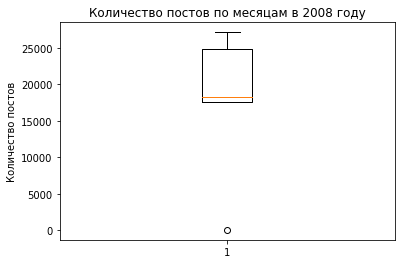

In [12]:
# построим диаграмму размаха

plt.boxplot(count_month['count'])

plt.title('Количество постов по месяцам в 2008 году')

plt.ylabel('Количество постов')

plt.show()

**На графике мы видим единичный вылет - аномально низкое значение. По датафрейму тоже это видно, аномальное значение наблюдается в августе, хотя по условиям задачи, должны были быть данные пользователей, которые зарегистрировались в сентябре. Скорее всего, в августе отобразились посты, написанные в ответ на чей-то вопрос. Августовское количество постов гораздо ниже, чем в остальные месяца.** 

# Задание 4

Используя данные о постах, выведем несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [13]:
# напишем запрос
query = '''

SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id   ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

# выполним запрос

count_views=pd.read_sql_query(query, con=engine)

count_views.head()

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509


# Задание 5

Найдем среднее количество постов пользователей в день за август 2008 года. Отберем данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитываем. 

Отсортируем результат по возрастанию среднего количества постов.

In [14]:
# напишем запрос
query = '''

WITH count_posts AS
(
SELECT user_id,
       DATE_TRUNC('day', creation_date)::date,
       COUNT(id) AS p_count
FROM stackoverflow.posts
WHERE user_id IN
    (
    SELECT user_id
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
    GROUP BY user_id
    HAVING COUNT(id) > 120
    )
GROUP BY user_id, DATE_TRUNC('day', creation_date)::date
)
SELECT count_posts.user_id,
       AVG(count_posts.p_count) AS avg_daily
FROM count_posts
WHERE DATE_TRUNC('month', count_posts.date_trunc)::date = '2008-08-01'
GROUP BY count_posts.user_id
ORDER BY avg_daily;
'''


# выполним запрос

count_posts=pd.read_sql_query(query, con=engine)

count_posts.head()

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберем дни, в которые он или она опубликовали хотя бы один пост. 

In [15]:
# напишем запрос
query = '''

WITH days AS
(
SELECT user_id,
       COUNT(DISTINCT DATE_TRUNC('day', creation_date)::date)
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id
)
SELECT ROUND(AVG(count))::int AS result
FROM days;
'''


# выполним запрос

days_avg=pd.read_sql_query(query, con=engine)

days_avg.head()

,result
0,2


**В период с 1 по 7 декабря 2008  пользователи взаимодействовали с платформой в среднем 2 дня**.

# Задание 7

Выведем историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируем вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавим в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрим внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [17]:
# напишем запрос
query = '''

WITH pred AS

(SELECT user_id,
         creation_date,
         LAG(creation_date, 2, NULL)  OVER(PARTITION BY user_id ORDER BY creation_date) AS pred_date
FROM stackoverflow.posts)

SELECT user_id,
       creation_date,
       to_char(pred_date, 'Month')
       
FROM pred
ORDER BY user_id, creation_date;
'''



# выполним запрос


activ=pd.read_sql_query(query, con=engine)

activ.head(7)

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August


# Задание 8

Рассчитаем аналог Retention Rate по месяцам для пользователей StackOverflow. Объединим пользователей в когорты по месяцу их первого поста. Возвращение определяем по наличию поста в текущем месяце. 

In [18]:
# напишем запрос
query = '''

WITH profile AS

(
WITH temp AS
(
SELECT DISTINCT user_id,
       FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER 
       (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date)) AS cohort_dt
FROM stackoverflow.posts      
)
SELECT *,
      COUNT(user_id) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
FROM temp
),

sessions AS 
(
SELECT user_id,
       DATE_TRUNC('month', creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY user_id, session_date)
         
         
SELECT p.cohort_dt AS cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile AS p
JOIN sessions AS s 
ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
ORDER BY cohort_dt, session_date;
'''

# выполнитм запрос

retention_rate=pd.read_sql_query(query, con=engine)

retention_rate

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


In [19]:
# построим тепловую карту Retention Rate

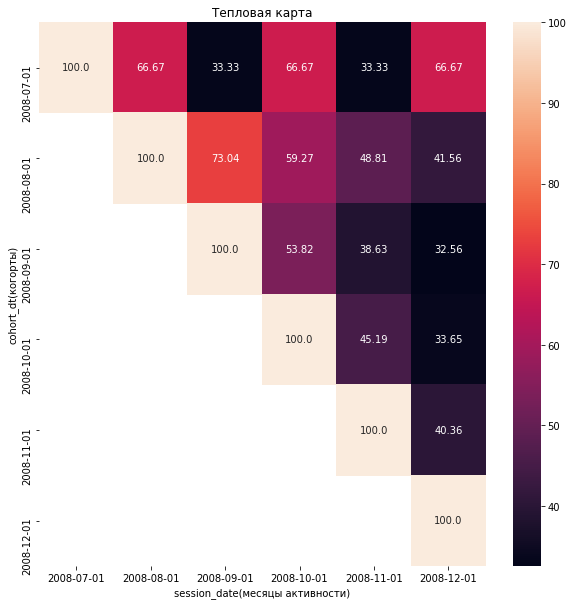

In [20]:
retention = retention_rate.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]
plt.figure(figsize=(10, 10)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта')
plt.xlabel('session_date(месяцы активности)')
plt.ylabel('cohort_dt(когорты)')
plt.show()

**Самый высокий коэффициент удержания был в сентябре по отношению к августу, также достаточно высокие в августе по отношению к июлю, в октябре по отношению к июлю и в декабре по отношению к июлю, а самые низкие показатели (33 %) были в сентябре по отношению к июлю, в ноябре по отношению к июлю, в декабре по отношению к сентябрю и в декабре по отношению к октябрю.
Если смотреть динамику по когортам, то в июльской когорте от месяца к месяцу чередуются самые высокие показатели удержания с самыми низкими, при этом, по таблице мы видим, что количество пользователей в целом очень низкое, и количество вернувшихся колеблется от 1-3 человек, поэтому зависимость коэффициента удержания очень чувствительная. Это был период теста платформы, поэтому, данные не показательны. В августовской когорте, а также в сентябрьской и октябрьской - идет постепенное уменьшение коэффициента удержания, вероятно интерес к площадке у пользователей ослабевал**

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразим таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлим значение процента до двух знаков после запятой.

В связи с тем, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз, переведем делимое в тип `numeric`.

In [21]:
# напишем запрос
query = '''

WITH count_posts AS
(
SELECT EXTRACT(MONTH FROM creation_date)::int AS creation_month,
       COUNT(id) AS posts_count
FROM stackoverflow.posts
WHERE EXTRACT(MONTH FROM creation_date)::int BETWEEN 9 AND 12
GROUP BY creation_month
)
SELECT *,
       ROUND((posts_count::numeric/LAG(posts_count) OVER()-1)*100, 2)
FROM count_posts;

'''


# выполним запрос



count_posts=pd.read_sql_query(query, con=engine)

count_posts.head(7)

,creation_month,posts_count,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Построим круговую диаграмму с количеством постов по месяцам.

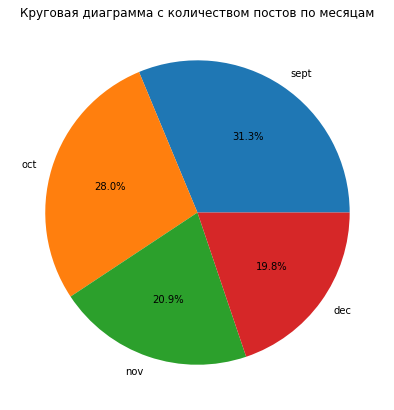

In [22]:
month = ['sept', 'oct', 'nov',
        'dec']
 
data = count_posts['posts_count']
 

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = month, autopct='%1.1f%%')
plt.title('Круговая диаграмма с количеством постов по месяцам')
 

plt.show()

**Наглядно видим, что в сентябре было самое большое количество постов**

# Задание 10

Выгрузим данные активности пользователя, который опубликовал больше всего постов за всё время. Выведем данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [23]:
# напишем запрос
query = '''
WITH active_user AS
(
SELECT user_id,
       COUNT(id)
FROM stackoverflow.posts
GROUP BY user_id
ORDER BY COUNT(id) DESC
LIMIT 1
)
SELECT EXTRACT(WEEK FROM p.creation_date)::int AS week_creation,
       MAX(p.creation_date) AS creation_date
FROM active_user AS au
JOIN stackoverflow.posts AS p
ON au.user_id=p.user_id
WHERE DATE_TRUNC('month', p.creation_date)::date = '2008-10-01'
GROUP BY week_creation;
'''

# выполним запрос

activ_user=pd.read_sql_query(query, con=engine)

activ_user.head(7)

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
